In [109]:
import os
import logging
from typing import TypedDict, Optional, List
from typing_extensions import Literal
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [110]:
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENWEATHER_API_KEY = os.getenv("OPENWEATHER_API_KEY")
OPENWEATHER_BASE_URL = os.getenv("OPENWEATHER_BASE_URL")


if not OPENAI_API_KEY:
    raise ValueError("❌ OPENAI_API_KEY is required! Please add it to your .env file")

if not OPENWEATHER_API_KEY:
    logger.warning("⚠️  OPENWEATHER_API_KEY not found - weather tool will use mock data")

if not OPENWEATHER_BASE_URL:
    logger.warning(
        "⚠️  OPENWEATHER_BASE_URL not found"
    )

print("✅ API keys validated")


✅ API keys validated


In [111]:
if OPENAI_API_KEY:
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

test_response = llm.invoke("Hello! Can you confirm you're working?")
print(f"🤖 LLM Test: {test_response.content}")

print("✅ ChatOpenAI instance created successfully")


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🤖 LLM Test: Hello! Yes, I'm here and ready to help. How can I assist you today?
✅ ChatOpenAI instance created successfully


In [112]:
class State(TypedDict, total=False):
    messages: List[BaseMessage]
    tool_used: Optional[Literal["weather", "math", "llm"]]
    result: Optional[str]

In [113]:
from pydantic import BaseModel, Field
from typing_extensions import Literal

class Route(BaseModel):
    step: Literal["weather", "math", "llm"] = Field(
        "llm", description="The next step in the routing process"
    )

router = llm.with_structured_output(Route)


In [114]:
def llm_call_router(state: State) -> State:
    """Route the input to the appropriate node"""

    logger.info("🔀 invoke routing")

    messages = state.get("messages", [])
    if not messages:
        logger.error("❌ No messages found in state")
        state["tool_used"] = "llm"
        return state
    
    human_message = next((msg for msg in reversed(messages) if isinstance(msg, HumanMessage)), None)
    if human_message is None:
        logger.error("❌ No HumanMessage found in messages")
        state["tool_used"] = "llm"
        return state

    logger.info(f"🔀 Human message: {human_message}")

    decision = router.invoke(
        [
            SystemMessage(
                content="Route the query to weather, math, or llm based on the user's request. Respond with only one word: 'weather', 'math', or 'llm'."
            ),
            human_message,
        ]
    )
    

    logger.info(f"🔀 Decision: {decision}")

    if decision.step == "weather": # type: ignore
        state["tool_used"] = "weather"
    elif decision.step == "math": # type: ignore
        state["tool_used"] = "math"
    else:
        state["tool_used"] = "llm"

    return state

In [115]:
from langchain.tools import tool
import httpx

@tool
def weather_tool(location: str) -> str:
    """Get weather information for a location."""
    if OPENWEATHER_API_KEY and OPENWEATHER_BASE_URL:
        logger.info(f"🌤️  Getting weather for {location}")

        with httpx.Client() as client:
            params = {
                "q": location,
                "appid": OPENWEATHER_API_KEY,
                "units": "metric",
            }

            logger.debug(f"�� Making API request to OpenWeather for {location}")
            response = client.get(OPENWEATHER_BASE_URL, params=params)
            response.raise_for_status()
            data = response.json()

            temp = data["main"]["temp"]
            description = data["weather"][0]["description"]
            country = data["sys"]["country"]

            result = f"It's {description} and {temp}°C in {location}, {country}."
            return result
    else:
        logger.info(f"🌤️  Mock weather data for {location}")
        return f"Mock weather: It's sunny and 22°C in {location}"


In [116]:
import re
@tool
def math_tool(expression: str) -> str:
    """Calculate mathematical expressions safely."""
    try:
        cleaned_expr = re.sub(r"[^0-9+\-*/%. ()]", "", expression)
        if not cleaned_expr:
            error_msg = (
                f"Expression '{expression}' contains no valid mathematical operations"
            )
            logger.error(f"❌ Math validation error: {error_msg}")
            return f"Error: {error_msg}"

        result = eval(cleaned_expr)
        result_str = str(result)

        return result_str
    except Exception as e:
        logger.error(f"❌ Math error: {e}")
        return f"Error: {str(e)}"


In [118]:
def agent_llm(state: State) -> State:
    """Handle general LLM queries without tools."""
    logger.info("🧠 Processing LLM query (no tools)")
    
    messages = state.get("messages", [])
    if not messages:
        logger.error("❌ No messages found in state")
        state["result"] = "No messages to process"
        return state
    
    result = llm.invoke(messages)
    
    content = result.content
    if isinstance(content, list):
        content = str(content)
    
    state["result"] = content

    return state

In [161]:
from langchain_core.messages import AIMessage


llm_weather_tool = llm.bind_tools([weather_tool])
llm_math_tool = llm.bind_tools([math_tool])

math_result = llm_math_tool.invoke([HumanMessage(content="How's is 7 multiply 3?")])


if isinstance(math_result, AIMessage) and hasattr(math_result, "tool_calls"):
    tool_calls = math_result.tool_calls
else:
    tool_calls = None 

tool_calls

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[{'name': 'math_tool',
  'args': {'expression': '7 * 3'},
  'id': 'call_RurflHU8yMi5RWcVaUKgo4sg',
  'type': 'tool_call'}]

In [162]:
llm_with_tools = llm.bind_tools([weather_tool, math_tool])

In [163]:
def route_decision(state: State) -> str:
    """Determine which path to take based on router decision."""
    logger.info("🔀 Making routing decision")
    
    tool_used = state.get("tool_used", "llm")
    result = tool_used or "llm"
    
    logger.info(f"🎯 Route decision: {result}")
    return result

In [166]:
from langchain_core.messages import AIMessage


def agent_llm_with_tools(state: State) -> State:
    """Handle tool-based queries using LLM tool binding for parameter extraction."""
    messages = state.get("messages", [])

    if not messages:
        logger.error("❌ No messages found in state")
        state["result"] = "No messages to process"
        return state

    llm_with_tools = {
        "weather": llm_weather_tool,
        "math": llm_math_tool,
    }

    try:
        tool_used = state.get("tool_used") or "weather"
        result = llm_with_tools[tool_used].invoke(messages)
        logger.info(f"🔍 LLM tool call result: {result}")

        if (
            isinstance(result, AIMessage)
            and hasattr(result, "tool_calls")
            and result.tool_calls
        ):
            tool_call = result.tool_calls[0]
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]

            logger.info(f"🔧 Tool: {tool_name}, Args: {tool_args}")

            tool_registry = {"weather_tool": weather_tool, "math_tool": math_tool}

            if tool_name in tool_registry:
                state["result"] = tool_registry[tool_name].invoke(tool_args)
            else:
                state["result"] = f"Unknown tool: {tool_name}"
        else:
            state["result"] = "No tool calls detected"

        logger.info(f"✅ Tool result: {state['result']}")

    except Exception as e:
        error_msg = f"Error processing tool query: {str(e)}"
        logger.error(f"❌ Tool processing error: {error_msg}")
        state["result"] = error_msg

    return state


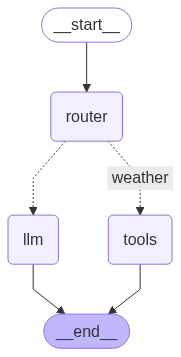

In [167]:
from IPython.core.display import Image

graph_builder = StateGraph(State)

graph_builder.add_node("llm", agent_llm)
graph_builder.add_node("tools", agent_llm_with_tools)
graph_builder.add_node("router", llm_call_router)


graph_builder.add_edge(START, "router")
graph_builder.add_conditional_edges(
    "router",
    route_decision,
    {
        "math": "tools",
        "weather": "tools",
        "llm": "llm",
    },
)

graph_builder.add_edge("llm", END)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [168]:
result = graph.invoke({"messages": [HumanMessage(content="What's the weather in Jakarta?")]})

result

INFO:__main__:🔀 invoke routing
INFO:__main__:🔀 Human message: content="What's the weather in Jakarta?" additional_kwargs={} response_metadata={}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:🔀 Decision: step='weather'
INFO:__main__:🔀 Making routing decision
INFO:__main__:🎯 Route decision: weather
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:🔍 LLM tool call result: content='' additional_kwargs={'tool_calls': [{'id': 'call_ZoSjWKwihMBZtyBX9VHIMNBF', 'function': {'arguments': '{"location":"Jakarta"}', 'name': 'weather_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 50, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model

{'messages': [HumanMessage(content="What's the weather in Jakarta?", additional_kwargs={}, response_metadata={})],
 'tool_used': 'weather',
 'result': "It's moderate rain and 33.13°C in Jakarta, ID."}

In [169]:
result = graph.invoke(
    {"messages": [HumanMessage(content="How's is 100 / 10?")]}
)

result

INFO:__main__:🔀 invoke routing
INFO:__main__:🔀 Human message: content="How's is 100 / 10?" additional_kwargs={} response_metadata={}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:🔀 Decision: step='math'
INFO:__main__:🔀 Making routing decision
INFO:__main__:🎯 Route decision: math
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:🔍 LLM tool call result: content='' additional_kwargs={'tool_calls': [{'id': 'call_Et0ezzksmUYQf2I24dMuJMlQ', 'function': {'arguments': '{"expression":"100 / 10"}', 'name': 'math_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 51, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mi

{'messages': [HumanMessage(content="How's is 100 / 10?", additional_kwargs={}, response_metadata={})],
 'tool_used': 'math',
 'result': '10.0'}

In [170]:
result = graph.invoke({"messages": [HumanMessage(content="Write simple poem about cats")]})

result


INFO:__main__:🔀 invoke routing
INFO:__main__:🔀 Human message: content='Write simple poem about cats' additional_kwargs={} response_metadata={}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:🔀 Decision: step='llm'
INFO:__main__:🔀 Making routing decision
INFO:__main__:🎯 Route decision: llm
INFO:__main__:🧠 Processing LLM query (no tools)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content='Write simple poem about cats', additional_kwargs={}, response_metadata={})],
 'tool_used': 'llm',
 'result': 'In sunlit spots, they stretch and play,  \nWith gentle purrs, they greet the day.  \nWhiskers twitch and tails held high,  \nChasing shadows as they fly.  \n\nSoft as clouds, with eyes so bright,  \nThey curl up close, a cozy sight.  \nMischief makers, sleek and sly,  \nIn every heart, they leave a sigh.  \n\nWith graceful leaps and playful bounds,  \nIn every home, their love abounds.  \nOh, little cats, so full of grace,  \nYou bring us joy, a warm embrace.  '}